# Estimación de Parámetros Críticos de la Percolación en la Grilla Cuadrada

### Integrantes:
    - Sebastián Gangas
    - Axel González
    - Enzo Toledo

## 0. Librerias

In [1]:
# Librerias
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from collections import deque
import networkx as nx
import numpy as np
import random
import time

## 1. Introducción al Marco Teórico del Proyecto

Se utilizará inicialmente la librería `networkx` para generar las conexiones en una matriz de $N$ x $N$, dadas por una `Bernoulli(p)` con $p \in [0,1]$ y un grafo simple $G = (V,E)$

El conjunto de vértices $V$ se define como:

$$V = \{0, 1, 2, \ldots, N^2 - 1\}$$

Y para el conjunto de aristas $E$, consideramos una variable aleatoria $U \sim Unif[0,1]$ tal que:

$$E = \{ (i, j) \in V \times V \mid \|i - j\| = 1 \text{ , } U < p \}$$

`Observación`: Notamos que a mayor $p$ la cantidad de aristas crece.

### 1.1. Tamaño de la Grilla

- Se genera una grilla de tamaño $N \times N$, donde $N$ debe ser preferentemente impar para asegurar que exista un centro exacto en la grilla.

### 1.2. Conexiones entre Nodos

- A cada arista de la grilla se le asigna un valor aleatorio uniforme en el intervalo $[0, 1]$.

- La existencia de una conexión entre nodos se define por una Bernoulli con parámetro $p$. Esto significa que la conexión entre dos nodos ocurre con probabilidad $p$.

### 1.3. Representación de la Grilla

- La grilla se representa utilizando una lista de adyacencia para cada nodo. La lista contiene las conexiones a los nodos adyacentes en las direcciones: izquierda, abajo, derecha y arriba.

- Si un valor en la lista es 0, significa que no existe una arista en esa dirección.

### 1.4. Ejemplo de Distribución de Índices en una Grilla $5 \times 5$

En una grilla de tamaño $5 \times 5$, los vértices se distribuyen de la siguiente manera:

<div align="center">

|   |   |   |   |   |
|---|---|---|---|---|
| 20 | 21 | 22 | 23 | 24 |
| 15 | 16 | 17 | 18 | 19 |
| 10 | 11 | 12 | 13 | 14 |
|  5 |  6 |  7 |  8 |  9 |
|  0 |  1 |  2 |  3 |  4 |

</div>

### 1.5. Ejemplo de Matriz de Adyacencia

Una posible matriz de adyacencia asociada a esta grilla sería la siguiente. En ella, cada fila representa un nodo, y las columnas corresponden a las direcciones: izquierda, abajo, derecha y arriba.

<div align="center">

| Nodo | Izquierda | Abajo | Derecha | Arriba |
|------|-----------|-------|---------|--------|
| 0    | 0         | 0     | 0.72    | 0.81   |
| 1    | 0.72      | 0     | 0.65    | 0.41   |
| 2    | 0.65      | 0     | 0.38    | 0.92   |
| 3    | 0.38      | 0     | 0.10    | 0.77   |
| ...  | ...       | ...   | ...     | ...    |
| 24   | 0.23      | 0.65  | 0       | 0      |

</div>

### 1.6. Observación

La columna 'Nodo' no forma parte de la matriz final. En su lugar, los índices de los nodos se deducen a partir del índice y el orden del arreglo entregado por la función implementada para generar la grilla.


## 2. Creación del Grafo

In [2]:
def asignacion_uniformes(N):

    """
    Genera variables aleatorias uniformes para la asignacion de los nodos en la grilla de N x N
    """

    return np.random.uniform(0,1, (N**2, 4)) 

In [4]:
# Ejemplo de asignacion de nodos en una grilla de 3x3
N = 3
asignacion = asignacion_uniformes(N)

asignacion # En la practica no se usan todas las uniformes, pero se generan rapido y se seleccionan las necesarias, siendo lo mas eficiente.

array([[0.58750883, 0.85416042, 0.67952976, 0.65587833],
       [0.28100163, 0.58020855, 0.57241102, 0.77182139],
       [0.31583239, 0.13728655, 0.55436339, 0.89058696],
       [0.3045931 , 0.16505877, 0.96186913, 0.53993942],
       [0.88980319, 0.11174034, 0.22257651, 0.0143044 ],
       [0.67005172, 0.41936186, 0.61074122, 0.84267403],
       [0.32177982, 0.82277058, 0.51595405, 0.55140564],
       [0.45975452, 0.98497548, 0.68388726, 0.90084232],
       [0.62211561, 0.09569714, 0.11598457, 0.39763198]])

In [5]:
def transformacion_matriz_grafo(matriz, p):

    """
    Transforma una matriz de adyacencia en un grafo de NetworkX.
    """

    N_cuadrado = len(matriz)
    N = int(np.sqrt(N_cuadrado))
    grafo = nx.Graph()

    # Se le agregan los vertices
    grafo.add_nodes_from(range(0,N_cuadrado)) # {0, 1, 2, ..., N^2-1}
   
    # Basta ir agregando solo las aristas hacia la derecha y hacia arriba
    for i in range(0,N_cuadrado):

        if (i % N != N - 1) and (matriz[i][2] <= p):      # Conexión a la derecha
            grafo.add_edge(i, i + 1)
        if (i + N < N_cuadrado) and (matriz[i][3] <= p):  # Conexión hacia arriba
            grafo.add_edge(i, i + N)    

    return grafo

In [7]:
# Ejemplo de transformacion de matriz a grafo:
N = 3
matriz = asignacion_uniformes(N)
p = 0.5
grafo = transformacion_matriz_grafo(matriz, p)

grafo.edges(), grafo.nodes()

(EdgeView([(0, 1), (2, 5), (4, 5), (5, 8), (6, 7)]),
 NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8)))

In [8]:
def sampleo_grafo(N, p, a=None):

    """
    Genera un grafo aleatorio de N x N con parametro de conexion p o con la matriz de adyacencia a fija si se especifica.
    """

    if a is not None:
        return transformacion_matriz_grafo(a, p)
    else:
        return transformacion_matriz_grafo(asignacion_uniformes(N), p)

## 3. Visualización del Grafo

In [9]:
def dibujar_grilla(grafo):

    """
    Dibuja un grafo de NetworkX en una grilla de N x N
    """

    N = int(np.sqrt(len(grafo.nodes())))  # largo de la grilla (N)

    fig, ax = plt.subplots()
    fig.set_size_inches(8, 8)

    # Creacion de las posiciones
    pos = {}
    for i in range(0, N):
        for k in range(0, N):
            pos[i * N + k] = (i, k)

    nx.draw(grafo, ax=ax, node_color='#000000', pos=pos, node_size=0)  # Ajuste de Nodos
    nx.draw_networkx_edges(grafo, pos, ax=ax, edge_color='red')        # Ajuste de Aristas
    ax.set_title(f"Grafo de {N}x{N} con parámetro p: {p}")

    # Marcar el centro del grafo. Si no hay centro exacto marca la casilla superior derecha inmediata.
    centro =  N//2 + N*(N//2)
    nx.draw_networkx_nodes(grafo, pos, nodelist=[centro], node_color='blue', node_size=20)

    plt.show()

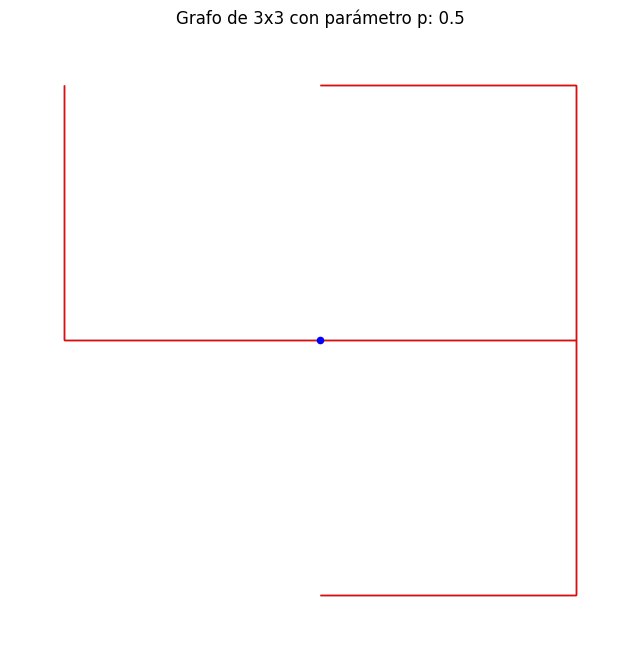

In [12]:
# Ejemplo de uso ( Ejecutar varias veces para ver distintos grafos )
N = 3
p = 0.5
grafo_ej = sampleo_grafo(N,p)
dibujar_grilla(grafo_ej)

## 4. GIF: Cambios en la grilla para distintos valores de $p$ y matriz de adyacencia fija

In [13]:
# Crear posiciones fijas para los nodos
def crear_posiciones_fijas(N):
    return {i * N + k: (k, -i) for i in range(N) for k in range(N)}

# Modificación para dibujar los grafos sin mover las posiciones
def dibujar_grilla_fija(grafo, p, ax, pos):
    
    ax.clear()                                      # Limpiar el eje antes de cada frame
    
    # Dibujar nodos y aristas
    nx.draw(grafo, ax=ax, node_color='#000000', pos=pos, node_size=0)
    nx.draw_networkx_edges(grafo, pos, ax=ax, edge_color='red')

    # Titulo con el valor actual de p
    ax.set_title(f"Grafo de {len(grafo.nodes())} nodos con parámetro p: {p:.2f}", fontsize=10)

    # Marcar el centro
    N = int(np.sqrt(len(grafo.nodes())))            # Obtener el tamaño de la grilla
    centro = N // 2 + N * (N // 2)
    nx.draw_networkx_nodes(grafo, pos, nodelist=[centro], node_color='blue', node_size=20)

# Crear el GIF
def generar_gif(N, ps, a1, output_filename):
    fig, ax = plt.subplots(figsize=(8, 8))          # Crear una figura única para todo el GIF
    writer = PillowWriter(fps=10)                   # Configurar velocidad del GIF
    
    # Fijar las posiciones de los nodos (solo se calculan una vez)
    pos = crear_posiciones_fijas(N)

    with writer.saving(fig, output_filename, dpi=100):
        for p in ps:
            grafo = sampleo_grafo(N, p, a1)         # Crear el grafo para el valor actual de p
            dibujar_grilla_fija(grafo, p, ax, pos)  # Dibujar el grafo en el eje con posiciones fijas
            writer.grab_frame()                     # Capturar el gráfico actual para el GIF

    #plt.close(fig)  # Cerrar la figura al finalizar

### 4.1 Descomentar celda inferior para generar un GIF (Con parámetros actuales; tiempo de ejecución de 2 segundos)

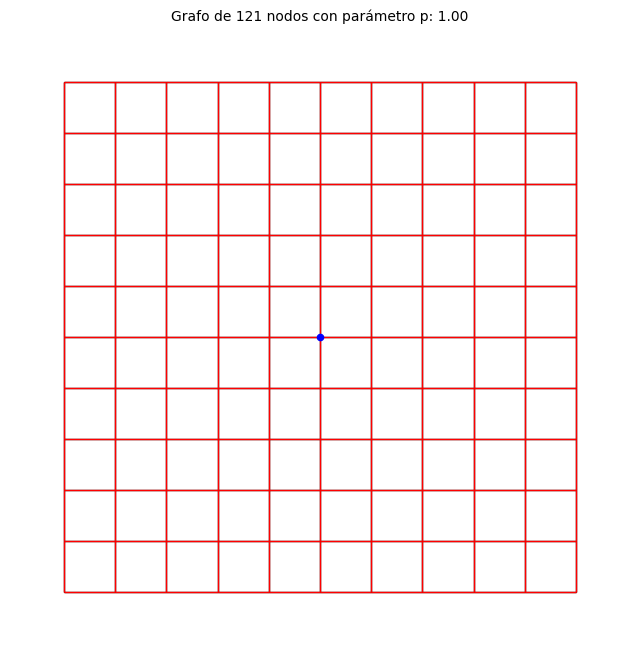

In [ ]:
# # Parámetros
# N = 11  # Tamaño de la grilla
# ps = np.linspace(0, 1, 30)  # Valores de p entre 0 y 1
# a1 = asignacion_uniformes(N)  # Asignación fija de uniformes
# output_filename = "grafos_grilla.gif"

# # Generar el GIF (almacenado en la carpeta actual) y muestra el frame final en el notebook.
# generar_gif(N, ps, a1, output_filename)

## 5. Caminos al infinito... (Camino al borde, búsqueda por DFs y componente conexa del $0$)

In [14]:
def esta_en_borde(nodo, N):

    """
    Determina si un nodo está en el borde de una grilla de N x N.
    """
    
    if nodo < N:                    # primera fila
        return True
    elif N**2 - N <= nodo < N**2:   # ultima fila
        return True
    elif nodo % N == 0:             # primera columna
        return True
    elif (nodo + 1) % N == 0:       # ultima columna
        return True
    else:
        return False

El nodo 0 está en el borde: True
El nodo 1 está en el borde: True
El nodo 2 está en el borde: True
El nodo 3 está en el borde: True
El nodo 4 está en el borde: False
El nodo 5 está en el borde: True
El nodo 6 está en el borde: True
El nodo 7 está en el borde: True
El nodo 8 está en el borde: True


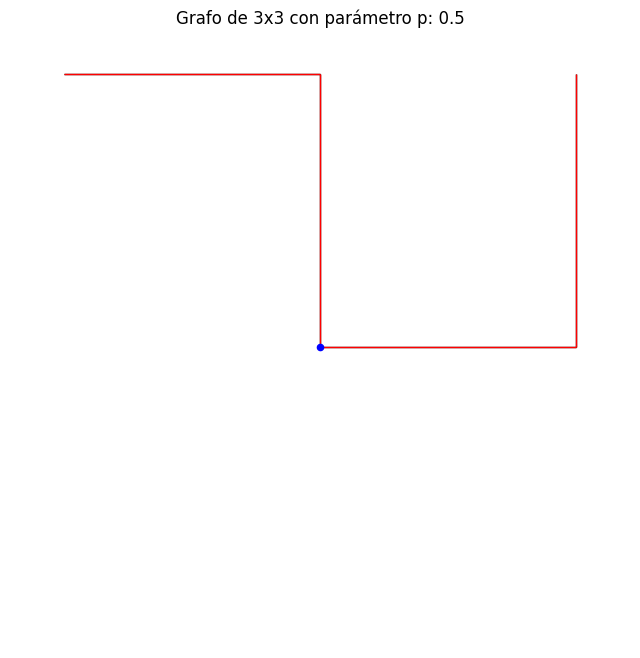

In [15]:
# Ejemplo de uso:
N = 3
for i in range(N**2):
    print(f"El nodo {i} está en el borde: {esta_en_borde(i, N)}")

G = sampleo_grafo(N, 0.5)
dibujar_grilla(G)

In [16]:
def existe_camino_origen_borde(G):

    """
    Determina si existe un camino desde el nodo central (0) de un grafo hasta el borde mediante una búsqueda en profundidad (DFS).
    """

    N = int(np.sqrt(len(G.nodes())))  # largo de la grilla

    # Inicialización del diccionario de nodos visitados
    visitado = {nodo: False for nodo in G.nodes()}

    # Calcula el nodo central
    origen = N//2 + N*(N//2)

    # Pila para la búsqueda DFS
    pila = deque([origen])   # Para iniciar condicion inicial altiro.
    visitado[origen] = True  # Marcar el origen como visitado

    # DFS
    while pila:              # Mientras la pila no sea vacia...
        nodo = pila.pop()

        # Verificar si el nodo está en el borde
        if esta_en_borde(nodo, N):
            return True

        # Explorar vecinos no visitados
        for vecino in list(G.neighbors(nodo)):
            if not visitado[vecino]:
                visitado[vecino] = True  # Marcamos como visitado
                pila.append(vecino)      # Agregamos a la pila

    # Si no se encontró un camino al borde
    return False

In [17]:
def existe_camino_origen_borde_para_dibujar(G):
    
    """
    Determina si existe un camino desde el nodo central (0) de un grafo hasta el borde mediante una búsqueda en profundidad (DFS).
    Además, devuelve las aristas visitadas durante la búsqueda.

    Devuelve:
        - (bool, edgearray): Un booleano indicando si existe un camino al borde y un array de aristas visitadas para dibujar posteriormente.
    """

    N = int(np.sqrt(len(G.nodes())))      # largo de la grilla

    # Inicialización del diccionario de nodos visitados
    visitado = {nodo: False for nodo in G.nodes()}

    # Calcula el nodo central
    origen = N//2 + N*(N//2)

    # Pila para la búsqueda DFS
    pila = deque([origen])
    visitado[origen] = True               # Marcar el origen como visitado

    # Array de las aristas que irá visitando
    aristas_visitadas = []

    # DFS
    while pila:
        nodo = pila.pop()

        # Verificar si el nodo está en el borde
        if esta_en_borde(nodo, N):
            return True, aristas_visitadas

        # Explorar vecinos no visitados
        for vecino in list(G.neighbors(nodo)):
            if not visitado[vecino]:
                visitado[vecino] = True  # Marcar como visitado
                pila.append(vecino)      # Agregar a la pila
                aristas_visitadas.append((nodo, vecino))

    # Si no se encontró un camino al borde
    return False, aristas_visitadas

In [18]:
def dibujar_grilla_busqueda_DFS(grafo):

    """
    Función que dibuja el grafo y resalta en azul la búsqueda realizada por el DFS para encontrar el camino (de exisitir) al borde.
    """

    booleano, componente_origen= existe_camino_origen_borde_para_dibujar(grafo)

    N = int(np.sqrt(len(grafo.nodes())))  # largo de la grilla (N)

    fig, ax = plt.subplots()
    fig.set_size_inches(8, 8)

    # Creacion de las posiciones
    pos = {}
    for i in range(0, N):
        for k in range(0, N):
            pos[i * N + k] = (i, k)

    nx.draw(grafo, ax=ax, node_color='#000000', pos=pos, node_size=0)    # Ajuste de Nodos
    nx.draw_networkx_edges(grafo, pos, ax=ax, edge_color='white')        # Ajuste de Aristas
    nx.draw_networkx_edges(grafo, pos, edgelist= componente_origen,ax=ax, edge_color= '#3357FF')
    ax.set_title(f"Búsqueda realizada por el DFS (N={N}, p={p})\n" f"¿Existe camino al borde?: {'Sí' if booleano else 'No'}")

    # Marcar el centro del grafo. Si no hay centro exacto marca la casilla superior derecha inmediata.
    centro =  N//2 + N*(N//2)

    nx.draw_networkx_nodes(grafo, pos, nodelist=[centro], node_color='blue', node_size=20)

    plt.show()

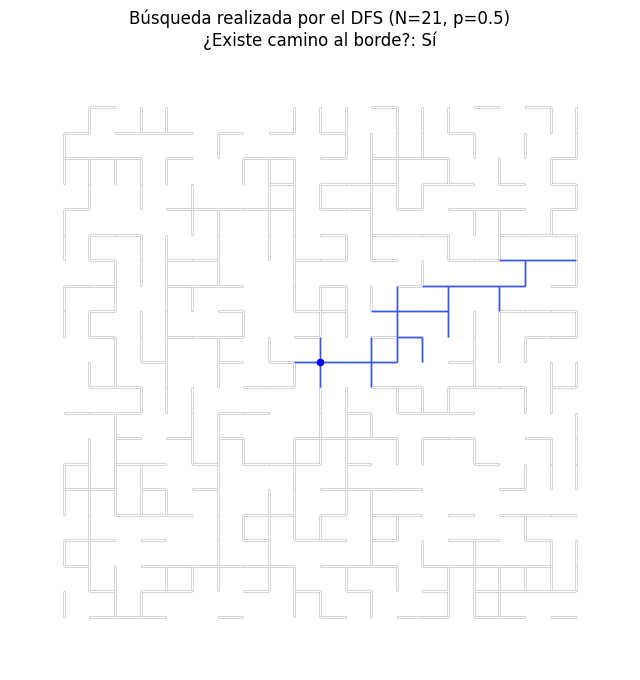

In [22]:
# Ejemplo de uso ( Ejecutar varias veces para ver distintos grafos )
N = 21
p = 0.5
grafo_ej = sampleo_grafo(N,p)
dibujar_grilla_busqueda_DFS(grafo_ej)

### 5.1 GIF: Animación paso a paso de la búsqueda realizada por el DFS

In [23]:
# Función para dibujar el grafo con aristas pintadas progresivamente
def dibujar_camino_borde_0_animado(grafo):

    """
    Función que dibuja el grafo y resalta en azul la búsqueda realizada por el DFS para encontrar el camino (de existir) al borde paso a paso (GIF).
    """
    
    # booleano indica si hay camino al borde y componente_origen son las aristas visitadas
    booleano, componente_origen = existe_camino_origen_borde_para_dibujar(grafo)

    N = int(np.sqrt(len(grafo.nodes())))  # Tamaño de la grilla
    fig, ax = plt.subplots(figsize=(8, 8))

    # Crear posiciones para los nodos
    pos = {i * N + k: (i, k) for i in range(N) for k in range(N)}

    # Iniciar visualización (sin aristas pintadas inicialmente)
    nx.draw(grafo, ax=ax, node_color='#000000', pos=pos, node_size=0)
    nx.draw_networkx_edges(grafo, pos, ax=ax, edge_color='white')

    # Función para actualizar la animación
    def animate(frame):

        ax.clear()  # Limpiar el frame anterior

        # Redibujar el grafo base (sin las aristas pintadas)
        nx.draw(grafo, ax=ax, node_color='#000000', pos=pos, node_size=0)
        nx.draw_networkx_edges(grafo, pos, ax=ax, edge_color='white')

        # Pintar las aristas hasta el frame actual (paso a paso del DFS)
        nx.draw_networkx_edges(grafo, pos, edgelist=componente_origen[:frame], ax=ax, edge_color='#3357FF')

        ax.set_title(f"Búsqueda realizada por el DFS (N={N}, p={p})\n"
                     f"¿Existe camino al borde?: {'Sí' if booleano else 'No'}")

        # Marcar el centro del grafo. Si no hay centro exacto marca la casilla superior derecha inmediata.
        centro = N // 2 + N * (N // 2)
        nx.draw_networkx_nodes(grafo, pos, nodelist=[centro], node_color='blue', node_size=20)

    # Crear la animación con el número de frames igual al número de aristas visitadas más uno si existe camino (para ver el frame final)
    frames = len(componente_origen) + 1 if booleano else len(componente_origen)
    anim = FuncAnimation(fig, animate, frames=frames, interval=200)

    return anim

### 5.1.1 Descomentar celda inferior para generar GIF: (Con parámetros actuales; tiempo de ejecución de 3 segundos aprox.)

`Observación:` Puede ocurrir que al ver el GIF este se corte en algún momento y vuelva a iniciar. Sin embargo, esto ocurre solo las primeras veces en que se visualiza y no corresponde a un error del código. El GIF se genera correctamente.

MovieWriter imagemagick unavailable; using Pillow instead.


Tiempo de ejecución: 2.1283276081085205


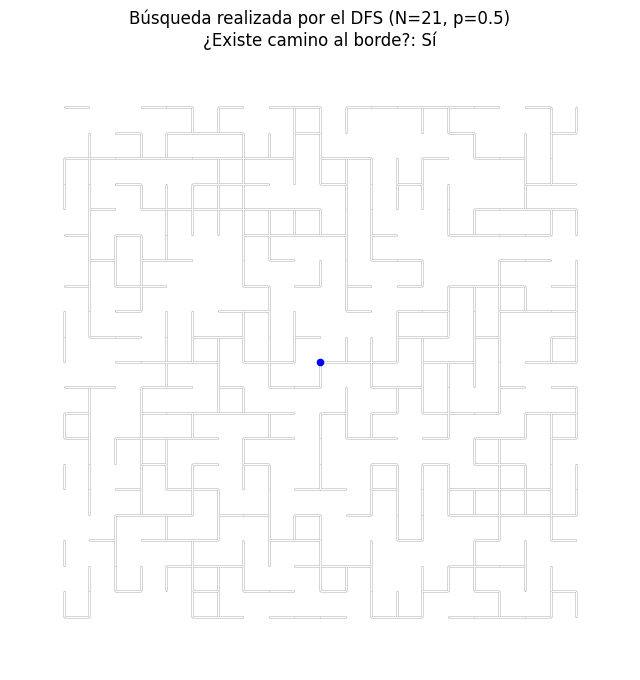

In [ ]:
# # Ejemplo de uso:

# start_time = time.time()

# N = 21
# p = 0.5
# grafo_ej = sampleo_grafo(N, p)

# anim = dibujar_camino_borde_0_animado(grafo_ej)

# # Guarda la animacion como GIF en la carpeta actual y muestra el frame inicial en el notebook.
# anim.save('DFS_0.gif', writer='imagemagick', fps=20)

# end_time = time.time()
# print(f"Tiempo de ejecución: {end_time - start_time}")

### 5.2 Componente Conexa del 0 (variación del DFS anterior)

In [24]:
def componente_conexa(G):
    
    """
    Determina la componente conexa del nodo central (0) en un grafo y si existe un camino al borde.
    """

    N = int(np.sqrt(len(G.nodes())))  # largo de la grilla

    # Verifica si existe camino al borde
    booleano, componente_origen = existe_camino_origen_borde_para_dibujar(G)

    # Inicialización del diccionario de nodos visitados
    visitado = {nodo: False for nodo in G.nodes()}

    # Calcula el nodo central
    origen = N // 2 + N * (N // 2)

    # Pila para la búsqueda DFS
    pila = deque([origen])
    visitado[origen] = True  # Marcar el origen como visitado

    # Array de las aristas que irá visitando
    aristas_visitadas = []

    while pila:
        nodo = pila.pop()
        # Explorar vecinos no visitados
        for vecino in list(G.neighbors(nodo)):
            if not visitado[vecino]:
                visitado[vecino] = True  # Marcar como visitado
                pila.append(vecino)       # Agregar a la pila
                aristas_visitadas.append((nodo, vecino))
            elif (nodo, vecino) not in aristas_visitadas and (vecino, nodo) not in aristas_visitadas:
                aristas_visitadas.append((nodo, vecino))

    return booleano, aristas_visitadas

In [25]:
def dibujar_componente_conexa_0(grafo):

    """
    Dibuja la componente conexa del nodo central (0) en un grafo y resalta en azul las aristas visitadas.
    """

    # booleano para ver si existe camino al borde y componente_origen para ver las aristas visitadas
    booleano, componente_origen = componente_conexa(grafo)

    N = int(np.sqrt(len(grafo.nodes())))  # largo de la grilla (N)

    fig, ax = plt.subplots()
    fig.set_size_inches(8, 8)

    # Creación de las posiciones
    pos = {}
    for i in range(0, N):
        for k in range(0, N):
            pos[i * N + k] = (i, k)

    nx.draw(grafo, ax=ax, node_color='#000000', pos=pos, node_size=0)  # Ajuste de Nodos
    nx.draw_networkx_edges(grafo, pos, ax=ax, edge_color='white')      # Ajuste de Aristas
    nx.draw_networkx_edges(grafo, pos, edgelist=componente_origen, ax=ax, edge_color='#3357FF')
    ax.set_title(f"Componente Conexa del $0$ (N={N}, p={p})\n" f"¿Existe camino al borde?: {'Sí' if booleano else 'No'}")

    # Marcar el centro del grafo. Si no hay centro exacto marca la casilla superior derecha inmediata.
    centro = N // 2 + N * (N // 2)
    nx.draw_networkx_nodes(grafo, pos, nodelist=[centro], node_color='blue', node_size=20)

    plt.show()

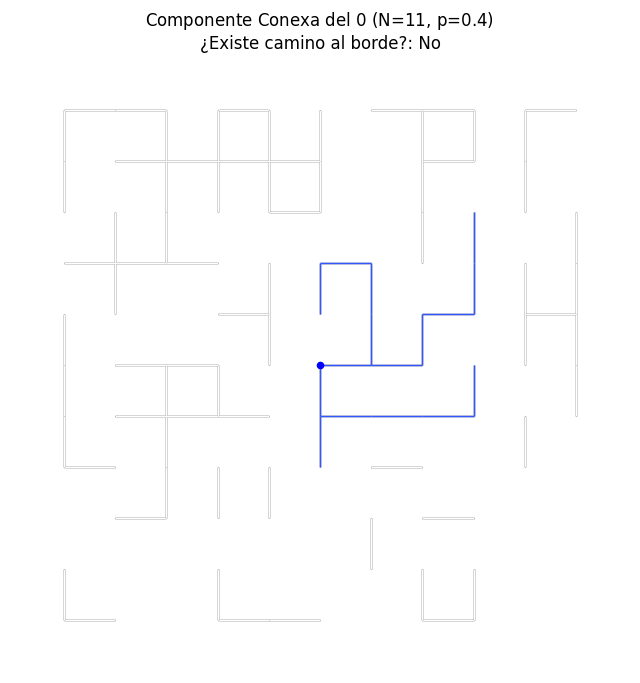

Tiempo de ejecución: 0.08114099502563477


In [34]:
# Ejemplo de uso ( Ejecutar varias veces para ver distintos grafos )

start_time = time.time()

N = 11
p = 0.4
grafo_ej = sampleo_grafo(N,p)
dibujar_componente_conexa_0(grafo_ej)

end_time = time.time()
print(f"Tiempo de ejecución: {end_time - start_time}")

### 5.2.1 GIF: Animación paso a paso de lo realizado por el DFS para encontrar la componente conexa del $0$

In [35]:
def dibujar_componente_conexa_0_animado(grafo):

    """
    Función que dibuja el grafo y resalta en azul la componente conexa del nodo central (0) de un grafo a medida que se construye (GIF).
    """

    # booleano indica si hay camino al borde y componente_origen son las aristas visitadas
    booleano, componente_origen = componente_conexa(grafo)

    N = int(np.sqrt(len(grafo.nodes())))  # Tamaño de la grilla
    fig, ax = plt.subplots(figsize=(8, 8))

    # Crear posiciones para los nodos
    pos = {i * N + k: (i, k) for i in range(N) for k in range(N)}

    # Iniciar visualización (sin aristas pintadas)
    nx.draw(grafo, ax=ax, node_color='#000000', pos=pos, node_size=0)
    nx.draw_networkx_edges(grafo, pos, ax=ax, edge_color='white')

    # Función para actualizar la animación
    def animate(frame):

        ax.clear()  # Limpiar el frame anterior

        # Redibujar el grafo base (sin las aristas pintadas)
        nx.draw(grafo, ax=ax, node_color='#000000', pos=pos, node_size=0)
        nx.draw_networkx_edges(grafo, pos, ax=ax, edge_color='white')

        # Pintar las aristas hasta el frame actual
        nx.draw_networkx_edges(grafo, pos, edgelist=componente_origen[:frame], ax=ax, edge_color='#3357FF')

        ax.set_title(f"Componente Conexa del $0$ (N={N}, p={p})\n"
                     f"¿Existe camino al borde?: {'Sí' if booleano else 'No'}")

        # Marcar el centro del grafo
        centro = N // 2 + N * (N // 2)
        nx.draw_networkx_nodes(grafo, pos, nodelist=[centro], node_color='blue', node_size=20)

    # Crear la animación con el número de frames igual al número de aristas visitadas
    anim = FuncAnimation(fig, animate, frames=len(componente_origen), interval=200)
    return anim

### 5.2.2 Descomentar celda inferior para generar un GIF (con parámetros actuales; tiempo de ejecución de 19 segundos aprox.)

`Observación:` Puede ocurrir que al ver el GIF este se corte en algún momento y vuelva a iniciar. Sin embargo, esto ocurre solo las primeras veces en que se visualiza y no corresponde a un error del código. El GIF se genera correctamente.

MovieWriter imagemagick unavailable; using Pillow instead.


Tiempo de ejecución: 18.76541233062744


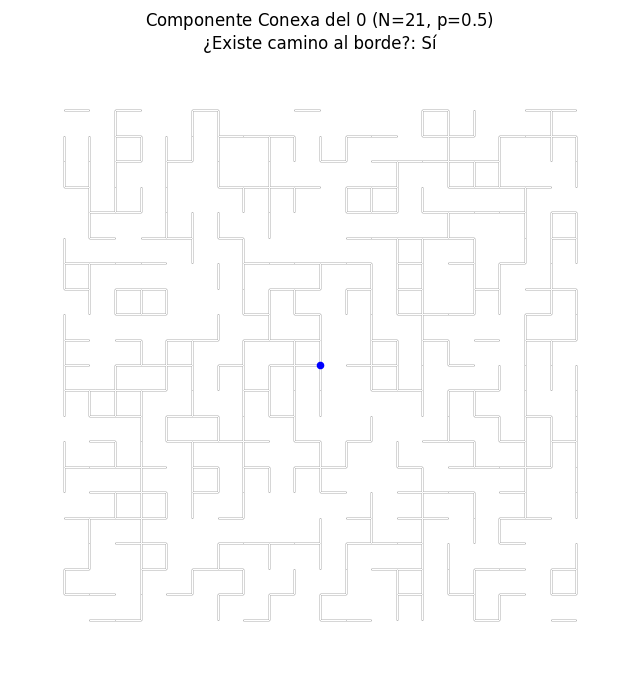

In [ ]:
# # Ejemplo de uso:

# start_time = time.time()

# N = 21
# p = 0.5
# grafo_ej = sampleo_grafo(N, p)

# anim = dibujar_componente_conexa_0_animado(grafo_ej)

# # Guarda la animacion como GIF en la carpeta actual y muestra el frame inicial en el notebook.
# anim.save('DFS_CC.gif', writer='imagemagick', fps=20)

# end_time = time.time()

# print(f"Tiempo de ejecución: {end_time - start_time}")

## 6. Estimación de Parámetros Críticos

Se pretende estudiar las tasas de convergencia de las simulaciones a los resultados teóricos de la percolación de Bernoulli en $\mathbb{Z}^2$. Para ello se estimarán los parámetros $\alpha$ y $c$ dados por la siguiente relación:

$$\mathbb{P}_p\left( \exists : 0 \leftrightarrow \partial G \right)= \begin{cases}k>0 & \text { si } p>1 / 2 \\ 0 \sim N^{-\alpha} & \text { si } p=1 / 2 \\ 0 \sim e^{-c N} & \text { si } p<1 / 2\end{cases}$$

### 6.1 Estimador de Monte Carlo

Comenzamos por estimar la probabilidad de que haya un camino del origen (centro definido anteriormente) al borde de una grilla de $N$ x $N$ con parámetro de probabilidad para las aristas de $p$ con respecto a un cierto $\textbf{número de iteraciones}$ realizadas.. Esto se realizará considerando simplemente $\frac{\textbf{Casos Favorables}}{\textbf{Casos Totales}}$.

In [36]:
def estimacion_conteo_empirico(N, p, numero_iteraciones):
    """
    Estima la probabilidad de que exista un camino desde el nodo central al borde de una grilla N x N 
    mediante un conteo empírico basado en un número dado de iteraciones.

    Parámetros:
        N (int): Tamaño de la grilla (N x N).
        p (float): Probabilidad de que exista una arista entre dos nodos.
        numero_iteraciones (int): Número de iteraciones para realizar la estimación.

    Retorna:
        tuple: Un arreglo con las probabilidades estimadas en cada iteración y un arreglo con las matrices de uniformes generadas.
    """

    # Se guardan las matrices de uniformes generadas en cada iteración
    uniformes = np.empty(numero_iteraciones, dtype=object)

    # Se guardan los resultados de las estimaciones en cada iteración
    arreglo_resultados = np.zeros(numero_iteraciones)
    
    # Conteo de las veces que existe un camino del origen al borde
    conteo_bernoulli_camino_valido = 0

    for k in range(1, numero_iteraciones + 1):
        matriz_uniformes = asignacion_uniformes(N)                # Genera la matriz de uniformes
        uniformes[k - 1] = matriz_uniformes                       # Guarda la matriz de uniformes
        grafo = transformacion_matriz_grafo(matriz_uniformes, p)  # Genera el grafo

        if existe_camino_origen_borde(grafo):
            conteo_bernoulli_camino_valido += 1

        # Probabilidad de que exista camino del origen al borde en la iteración k
        arreglo_resultados[k - 1] = conteo_bernoulli_camino_valido / k

    return arreglo_resultados, uniformes

In [37]:
def graficar_estimacion(valores, N, p, nf):

    """
    Grafica la estimación de la probabilidad de que exista un camino desde el nodo central al borde de una grilla N x N.
    """
    
    fig, ax = plt.subplots()
    y = valores
    x = np.arange(len(valores))
    final = valores[len(valores)-1]
    plt.plot(x, y, label="Valor final = " + str(final))
    plt.title(f'$P\\left( \\exists : 0 \\leftrightarrow \\partial G \\right) \\, (N={N}, \\, p={p}, \\, \\text{{nf}}={nf})$')
    plt.xlabel('Cantidad iteraciones')
    plt.ylabel('Probabilidad de que exista camino al borde')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

In [38]:
def graficar_estimacion_log(valores, Ns, p, nf):

    """
    Grafica la estimación de la probabilidad de que exista un camino desde el nodo central al borde de una grilla N x N en escala logarítmica
    según las transformaciones adecuadas para el cálculo de cada parámetro. Devuelve los parámetros respectivos por regresión lineal.
    """

    fig, ax = plt.subplots()
    y = np.array(valores)
    x = np.array(Ns)

    # Filter out zero values to avoid log(0)
    non_zero_indices = y > 0
    y_non_zero = y[non_zero_indices]
    x_non_zero = x[non_zero_indices]

    if p < 1/2:
        # Ajuste lineal (regresión)
        coeficientes = np.polyfit(x_non_zero, -np.log(y_non_zero), 1)  # Grado 1 para línea recta
        pendiente = coeficientes[0]
        intercepto = coeficientes[1]

        plt.plot(x_non_zero, -np.log(y_non_zero), label="Datos (-log)")
        plt.plot(x_non_zero, pendiente * x_non_zero + intercepto, '--', label=f"Ajuste lineal (c = {pendiente:.3f})") # Estimacion de c
        plt.title(f'$P\\left( \\exists : 0 \\leftrightarrow \\partial G \\right) \\, (N={Ns[-1]}, \\, p={p}, \\, \\text{{nf}}={nf})$')
        plt.xlabel('N')
        plt.ylabel('Probabilidad de que exista camino al borde (-log)')
        plt.legend()
        plt.show()
    elif p > 1/2:
        final = y[len(valores)-1]
        plt.plot(x, y, label=f"constante = {final}") # Consante final
        plt.title(f'$P\\left( \\exists : 0 \\leftrightarrow \\partial G \\right) \\, (N={Ns[-1]}, \\, p={p}, \\, \\text{{nf}}={nf})$')
        plt.xlabel('N')
        plt.ylabel('Probabilidad de que exista camino al borde')
        plt.legend()
        plt.show()
    else:
        # Ajuste lineal (regresión)
        coeficientes = np.polyfit(np.log(x_non_zero), -np.log(y_non_zero), 1)  # Grado 1 para línea recta
        pendiente = coeficientes[0]
        intercepto = coeficientes[1]

        plt.plot(np.log(x_non_zero), -np.log(y_non_zero), label="Datos (log)")
        plt.plot(np.log(x_non_zero), pendiente * np.log(x_non_zero) + intercepto, '--', label=f"Ajuste lineal ($\\alpha$ = {pendiente:.3f})") # Estimacion de alpha
        plt.title(f'$P\\left( \\exists : 0 \\leftrightarrow \\partial G \\right) \\, (N={Ns[-1]}, \\, p={p}, \\, \\text{{nf}}={nf})$')
        plt.xlabel('log(N)')
        plt.ylabel('Probabilidad de que exista camino al borde (-log)')
        plt.legend()
        plt.show()

    return pendiente

### 6.1.1 Estimación de $c$ por Monte Carlo

Teóricamente se sabe que este $c = c(p)$ por lo que para cada $p$ se obtendrá un $c$ distinto. Sin embargo, es posible observar un comportamiento lógico si consideramos como avanza este parámetro en las simulaciones a medida que $p$ crece hasta llegar a 1/2. A continuación se presentan solo algunas simulaciones para mostrar el comportamiento de las funciones. Sin embargo, los testeos reales realizados para esto se dejaron para ser presentados durante la presentación. Se señalan los tiempos de ejecución aproximados por si desean ser generados.

N=3, estimacion=0.905
N=4, estimacion=0.891
N=5, estimacion=0.808
N=6, estimacion=0.778
N=7, estimacion=0.748
N=8, estimacion=0.736
N=9, estimacion=0.691
N=10, estimacion=0.658
N=11, estimacion=0.641
N=12, estimacion=0.609
N=13, estimacion=0.598
N=14, estimacion=0.588
N=15, estimacion=0.553
N=16, estimacion=0.562
N=17, estimacion=0.548
N=18, estimacion=0.494
N=19, estimacion=0.484
N=20, estimacion=0.492
N=21, estimacion=0.472
N=22, estimacion=0.486
N=23, estimacion=0.402
N=24, estimacion=0.406
N=25, estimacion=0.395
N=26, estimacion=0.382
N=27, estimacion=0.355
N=28, estimacion=0.331
N=29, estimacion=0.356
N=30, estimacion=0.371
N=31, estimacion=0.324
N=32, estimacion=0.323
N=33, estimacion=0.315
N=34, estimacion=0.286
N=35, estimacion=0.285
N=36, estimacion=0.275
N=37, estimacion=0.259
N=38, estimacion=0.265
N=39, estimacion=0.229
N=40, estimacion=0.24
N=41, estimacion=0.21
N=42, estimacion=0.224
N=43, estimacion=0.19
N=44, estimacion=0.218
N=45, estimacion=0.199
N=46, estimacion=0.16

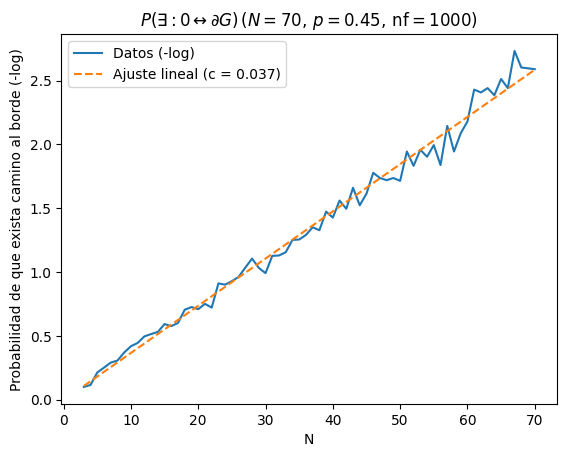

np.float64(0.036993931650022335)

In [ ]:
# Ejemplo: ( Tiempo de ejecución de 5m 8 segundos aprox )

start_time = time.time()

Ns = np.linspace(3, 70, 67, dtype=int)
p = 0.45
nf = 1000
estimacion0 = []

for N in Ns:
    valores1, uniformes1 = estimacion_conteo_empirico(N, p, nf)
    estimacion0.append(valores1[-1])
    print(f"N={N}, estimacion={valores1[-1]}")

end_time = time.time()
print(f"Tiempo de ejecución: {end_time - start_time}")

graficar_estimacion_log(estimacion0, Ns, p, nf)

### 6.1.2 Estimación de $\alpha$ por Monte Carlo

Teóricamente se sabe que este $\alpha = 5/48 \approx 0.1041666...$. A continuación se presentan solo algunas simulaciones para mostrar el comportamiento de las funciones. Sin embargo, los testeos reales realizados para esto se dejaron para ser presentados durante la presentación y se hallaron resultados consistentes a lo teórico. Se señalan los tiempos de ejecución aproximados por si desean ser generados.

N=10, estimacion=0.795
N=11, estimacion=0.788
N=12, estimacion=0.795
N=13, estimacion=0.783
N=14, estimacion=0.782
N=15, estimacion=0.79
N=16, estimacion=0.792
N=17, estimacion=0.802
N=18, estimacion=0.772
N=19, estimacion=0.766
N=20, estimacion=0.76
N=21, estimacion=0.743
N=22, estimacion=0.762
N=23, estimacion=0.751
N=24, estimacion=0.727
N=25, estimacion=0.743
N=26, estimacion=0.724
N=27, estimacion=0.721
N=28, estimacion=0.726
N=29, estimacion=0.715
N=30, estimacion=0.704
N=31, estimacion=0.705
N=32, estimacion=0.729
N=33, estimacion=0.707
N=34, estimacion=0.704
N=35, estimacion=0.716
N=36, estimacion=0.713
N=37, estimacion=0.707
N=38, estimacion=0.69
N=39, estimacion=0.699
N=40, estimacion=0.69
N=41, estimacion=0.687
N=42, estimacion=0.697
N=43, estimacion=0.682
N=44, estimacion=0.696
N=45, estimacion=0.708
N=46, estimacion=0.706
N=47, estimacion=0.689
N=48, estimacion=0.716
N=49, estimacion=0.685
N=50, estimacion=0.671
N=51, estimacion=0.685
N=52, estimacion=0.673
N=53, estimacio

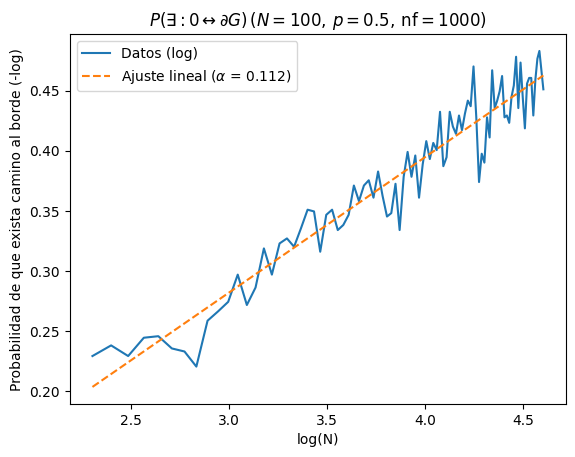

np.float64(0.11237971604370937)

In [105]:
# Ejemplo: ( Tiempo de ejecución de 20 minutos aprox)

start_time = time.time()

Ns = np.linspace(10, 100, 90, dtype=int)
p = 0.5
nf = 1000
estimacion0 = []

for N in Ns:
    valores1, uniformes1 = estimacion_conteo_empirico(N, p, nf)
    estimacion0.append(valores1[-1])
    print(f"N={N}, estimacion={valores1[-1]}")

end_time = time.time()
print(f"Tiempo de ejecución: {end_time - start_time}")

graficar_estimacion_log(estimacion0, Ns, p, nf)

### 6.2 Estimador Recursivo ( Restart )

Primer acercamiento al estimador recursivo mediante la tecnica de Restart. La idea principal es agrandar la matriz e ir tomando los casos favorables para agrandarla ( estimación de eventos de probabilidad 0)

In [39]:
def agrandar_matriz(N2, matriz):
    """
    Función que dado una matriz aleatoria de aristas de tamaño N1 la agranda a tamaño N2 agregándole aristas uniformes(0,1).
    USAR SOLO N1 Y N2 IMPARES.
    
    Parámetros:
    N2 (int): Tamaño de la nueva matriz (N2 x N2).
    matriz (numpy.ndarray): Matriz original de aristas de tamaño N1 x N1.

    Retorna:
    numpy.ndarray: Nueva matriz de aristas de tamaño N2 x N2.
    """
    
    N1 = int(np.sqrt(len(matriz)))  # Tamaño de la matriz original
    N2_cuadrado = N2**2
    matriz_nueva = np.zeros((N2_cuadrado, 4))

    contador_matriz_original = 0
    for i in range(0, N2_cuadrado):
        # Copia de la matriz original
        if not i < (N2-N1)//2*N2 and not i > N2_cuadrado - (N2-N1)//2*N2 and not i % N2 < (N2-N1)//2 and not i % N2 >= N2 - (N2-N1)//2:
            matriz_nueva[i] = matriz[contador_matriz_original]
            contador_matriz_original += 1

        # Revisa si hay que agregar arista hacia la derecha
        if i % N2 < (N2-N1)//2 or i % N2 >= N2 - (N2-N1)//2 - 1 or i < N2*(N2-N1)//2 or i > N2_cuadrado - (N2)*(N2-N1)//2 - 1:
            if i % N2 == N2 - 1:  # Si está en la última columna
                derecha = 0
            else:
                derecha = random.random()
                matriz_nueva[i+1][0] = derecha  # Asignar la misma arista en el nodo de la derecha (simetría)
            matriz_nueva[i][2] = derecha

        # Revisa si hay que agregar arista hacia arriba
        if i < N2*(N2-N1)//2 or i > N2_cuadrado - (N2)*(N2-N1)//2 - N2 - 1 or i % N2 < (N2-N1)//2 or i % N2 >= N2 - (N2-N1)//2:
            if i + N2 >= N2_cuadrado:  # Si está en la última fila
                arriba = 0
            else:
                arriba = random.random()
                matriz_nueva[i+N2][1] = arriba
            matriz_nueva[i][3] = arriba

    return matriz_nueva

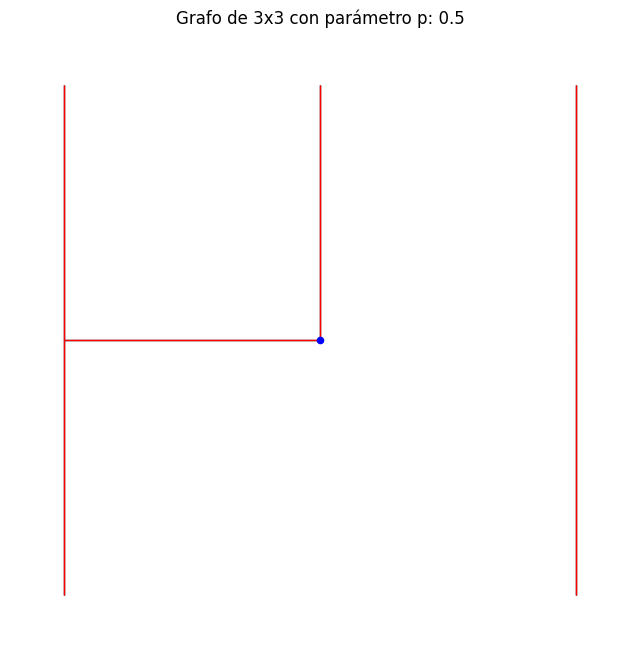

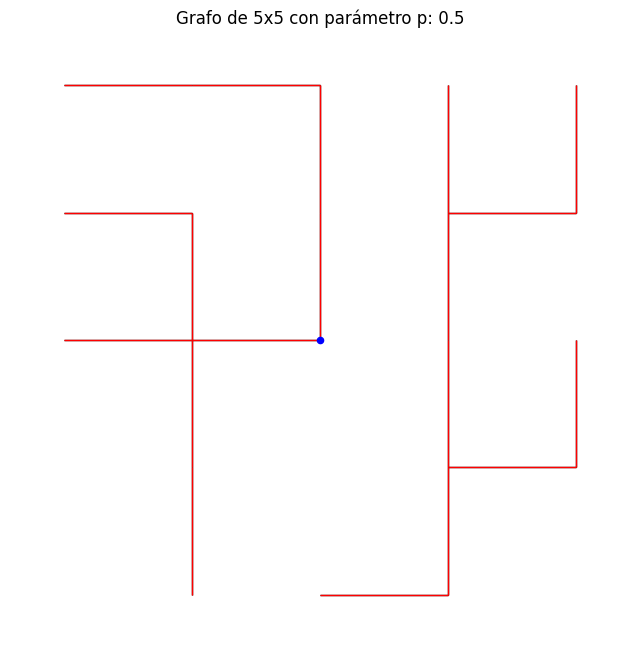

(None, None)

In [41]:
# Ejemplo de uso y visualización de la matriz agrandada
N1 = 3
N2 = 5
p = 0.5
matriz_adj = asignacion_uniformes(N1)
matriz_grande = agrandar_matriz(N2, matriz_adj)

# Visualización de la matriz más pequeña primero y luego su versión agrandada:
dibujar_grilla(transformacion_matriz_grafo(matriz_adj, p)), dibujar_grilla(transformacion_matriz_grafo(matriz_grande, p))

In [42]:
# Estimador como lo entendí : samplea M grafos iniciales y cuenta los que llegaron al borde de tamaño N1 y los guarda.
# De las iteraciones buenas, se agrandan a tamaño N2 y se cuenta cuantos llegan al borde de esos y se va iterando de esta manera hasta llegar al tamaño final N.
# el estimador de la probabilidad de llegar al borde del grafo de tamaño N va a ser la cantidad de grafos que llegaron al borde de tamaño N dividido por la cantidad de grafos
# que se debio ocupar para haber llegado a ese numero de grafos que llegaron al borde de tamaño N (que va a ser más que los sampleados pq solo se toman las buenas iteraciones para ir avanzando)

# N = tamaño de la grilla cuadrada NxN inicial, 
# p= probabilidad de la bernoulli de que exista la arista, 
# C=en cuanto se agranda la grilla cada vez, nf=cantidad de veces que se agranda la grilla, 
# M = cantidad de grafos iniciales a samplear, 
# L=cantidad de grafos creados a partir de un grafo bueno
# salida: grafos_buenos = deque de grafos que llegaron al borde en cada iteracion, 
# cantidad_grafos_buenos = arreglo de largo nf+1 que tiene la cantidad de grafos buenos en cada iteracion, 
# estimacion = estimador dado por el profesor ( Idea del Restart )

def estimador_2(N, p, C, nf, M, L):

    """
    Estima la probabilidad de que exista un camino desde el origen hasta el borde en un grafo de tamaño N.
    Parámetros:
    N (int): Tamaño inicial de la matriz.
    p (float): Probabilidad de que una arista exista en el grafo.
    C (int): Incremento en el tamaño de la matriz en cada iteración.
    nf (int): Número de iteraciones de crecimiento de la matriz.
    M (int): Número de grafos iniciales a generar.
    L (int): Número de veces que se agranda cada grafo en cada iteración. (cantidad de grafos iniciales a samplear)

    Retorna:
    matrices_buenas (deque): Grafos que tienen un camino desde el origen hasta el borde después de nf iteraciones.
    cantidad_grafos_buenos (numpy.ndarray): Cantidad de grafos buenos en cada iteración.
    estimacion (float): Estimación de la probabilidad de que exista un camino desde el origen hasta el borde en el grafo de tamaño N.
    """

    # Grafos en los que se va a seguir iterando
    matrices_buenas = deque()
    # arreglo para ir guardando la cantidad de grafos buenos en cada iteracion
    cantidad_grafos_buenos = np.zeros(nf+1)

    # iteración inicial
    for k in range(M):
        unif = asignacion_uniformes(N)
        grafo = transformacion_matriz_grafo(unif, p)
        if existe_camino_origen_borde(grafo):
            matrices_buenas.append(unif)
            cantidad_grafos_buenos[0]+=1

    # loop que va agrandando los grafos buenos
    for i in range(nf):

        matrices_nuevas = deque()
        for matriz in matrices_buenas:
            for k in range(L):
                unif = agrandar_matriz(N+C*(i+1), matriz)          # agranda la matriz de forma aleatoria
                grafo_nuevo = transformacion_matriz_grafo(unif, p)
                if existe_camino_origen_borde(grafo_nuevo):        # existe camino al borde en este nuevo grafo más grande
                    matrices_nuevas.append(unif)                   # guarda el grafo bueno
                    cantidad_grafos_buenos[i+1]+=1

        matrices_buenas = matrices_nuevas                          # siguiente iteracion, se sigue con los grafos buenos
    
    estimacion = cantidad_grafos_buenos[nf]/(M*L**nf)              # estimacion de la probabilidad de que exista camino al borde en el grafo de tamaño N

    return matrices_buenas, cantidad_grafos_buenos, estimacion


`Observación:` El estimador anterior resulta ser bastante lento, por lo tanto, se optó por modificarlo y realizar una versión recursiva de este:

In [44]:
# estimador recursivo que no guarda tantos grafos
# de hecho debería tener solo nf+1 grafos en memoria a lo largo del programa, que es una mejora muy sustancial c/r a lo de antes

# todos los otros parámetros como el estimador de arriba
def avance_recursivo(N, p, C, nf, M, L, unif_actual=None, nf_actual=0):
    # iteración inicial
    if unif_actual is None:
        unif_actual = asignacion_uniformes(N)

    G = transformacion_matriz_grafo(unif_actual, p)

    if existe_camino_origen_borde(G):
        if nf_actual == nf: # profundida maxima de recursion
            return 1
        else:
            caminos_totales = 0
            for k in range(L):
                print("Profundidad actual = " + str(N+C*(nf_actual+1)) + " y L actual = " + str(k))
                unif_agrandada = agrandar_matriz(N+C*(nf_actual+1), unif_actual)
                caminos_totales += avance_recursivo(N, p, C, nf, M, L, unif_agrandada, nf_actual+1)
                # esto sería como: caminos totales = caminos actuales + caminos que se obtienen de la siguiente iteracion al agrandar el grafo, tomando en cuenta los generados por L y todo eso
            return caminos_totales # el return afuera del for obvio

    else:
        return 0

def estimador_final(N, p, C, nf, M, L):
    caminos_totales = 0
    for k in range(M):
        print("Iteracion actual= " + str(k))
        caminos_totales += avance_recursivo(N, p, C, nf, M, L)
        
    estimacion = caminos_totales/(M*L**nf)
    return estimacion, M*L**nf, caminos_totales

### 6.2.1 Breve Presentación de Testeos realizados:

In [93]:
estimacion, grafos, caminos_totales = estimador_final(N=3, p=0.3, C=2, nf=10, M=1000, L=2) # usar solo N impares
estimacion, grafos, caminos_totales

Iteracion actual= 0
Iteracion actual= 1
Profundidad actual = 5 y L actual = 0
Profundidad actual = 7 y L actual = 0
Profundidad actual = 9 y L actual = 0
Profundidad actual = 11 y L actual = 0
Profundidad actual = 11 y L actual = 1
Profundidad actual = 9 y L actual = 1
Profundidad actual = 7 y L actual = 1
Profundidad actual = 5 y L actual = 1
Profundidad actual = 7 y L actual = 0
Profundidad actual = 9 y L actual = 0
Profundidad actual = 9 y L actual = 1
Profundidad actual = 11 y L actual = 0
Profundidad actual = 13 y L actual = 0
Profundidad actual = 13 y L actual = 1
Profundidad actual = 15 y L actual = 0
Profundidad actual = 15 y L actual = 1
Profundidad actual = 17 y L actual = 0
Profundidad actual = 19 y L actual = 0
Profundidad actual = 21 y L actual = 0
Profundidad actual = 21 y L actual = 1
Profundidad actual = 19 y L actual = 1
Profundidad actual = 17 y L actual = 1
Profundidad actual = 11 y L actual = 1
Profundidad actual = 7 y L actual = 1
Profundidad actual = 9 y L actual 

(0.0021435546875, 1024000, 2195)

In [94]:
estimacion2, grafos2, caminos_totales2 = estimador_final(N=3, p=0.4, C=2, nf=10, M=20, L=2) # usar solo N impares
estimacion2, grafos2, caminos_totales2

Iteracion actual= 0
Profundidad actual = 5 y L actual = 0
Profundidad actual = 5 y L actual = 1
Iteracion actual= 1
Profundidad actual = 5 y L actual = 0
Profundidad actual = 7 y L actual = 0
Profundidad actual = 7 y L actual = 1
Profundidad actual = 5 y L actual = 1
Profundidad actual = 7 y L actual = 0
Profundidad actual = 9 y L actual = 0
Profundidad actual = 11 y L actual = 0
Profundidad actual = 13 y L actual = 0
Profundidad actual = 15 y L actual = 0
Profundidad actual = 15 y L actual = 1
Profundidad actual = 13 y L actual = 1
Profundidad actual = 11 y L actual = 1
Profundidad actual = 9 y L actual = 1
Profundidad actual = 11 y L actual = 0
Profundidad actual = 13 y L actual = 0
Profundidad actual = 13 y L actual = 1
Profundidad actual = 11 y L actual = 1
Profundidad actual = 13 y L actual = 0
Profundidad actual = 15 y L actual = 0
Profundidad actual = 17 y L actual = 0
Profundidad actual = 19 y L actual = 0
Profundidad actual = 21 y L actual = 0
Profundidad actual = 23 y L actua

(0.09755859375, 20480, 1998)

In [102]:
estimacion3, grafos3, caminos_totales3 = estimador_final(N=21, p=0.45, C=2, nf=10, M=10, L=2) # usar solo N impares
estimacion3, grafos3, caminos_totales3

Iteracion actual= 0
Iteracion actual= 1
Profundidad actual = 23 y L actual = 0
Profundidad actual = 25 y L actual = 0
Profundidad actual = 27 y L actual = 0
Profundidad actual = 29 y L actual = 0
Profundidad actual = 31 y L actual = 0
Profundidad actual = 33 y L actual = 0
Profundidad actual = 35 y L actual = 0
Profundidad actual = 37 y L actual = 0
Profundidad actual = 39 y L actual = 0
Profundidad actual = 41 y L actual = 0
Profundidad actual = 41 y L actual = 1
Profundidad actual = 39 y L actual = 1
Profundidad actual = 41 y L actual = 0
Profundidad actual = 41 y L actual = 1
Profundidad actual = 37 y L actual = 1
Profundidad actual = 39 y L actual = 0
Profundidad actual = 41 y L actual = 0
Profundidad actual = 41 y L actual = 1
Profundidad actual = 39 y L actual = 1
Profundidad actual = 35 y L actual = 1
Profundidad actual = 37 y L actual = 0
Profundidad actual = 39 y L actual = 0
Profundidad actual = 41 y L actual = 0
Profundidad actual = 41 y L actual = 1
Profundidad actual = 39 

(0.24453125, 10240, 2504)

## 7. Grafo Dual y Estimador Promedio Componente Conexas

In [45]:
def transformacion_matriz_grafo_primal(matriz, p):

    """
    Transforma una matriz de aristas en un grafo de NetworkX. Corresponde a un reajuste de la primera función creada, pero para
    poder ser utilizada junto al dual que se construye luego.
    """
    
    N = int(np.sqrt(len(matriz)))
    grafo = nx.Graph()

    # Se le agregan los vertices
    grafo.add_nodes_from(range(0, N**2))  # {0, 1, 2, ..., N^2-1}

    # Para cada arista en primal, debemos revisar si
    for i in range(0, N**2):
        if (i % N != N - 1) and (matriz[i][0] <= p):  # Conexión a la derecha en el primal
            grafo.add_edge(i, i + 1)
        if (i + N < N**2) and (matriz[i][1] <= p):  # Conexión hacia arriba en el primal
            grafo.add_edge(i, i + N)

    return grafo

In [46]:
def transformacion_matriz_grafo_dual(matriz, p):
    N_dual = int(np.sqrt(len(matriz))) - 1
    grafo_dual = nx.Graph()

    # Se le agregan los vertices
    grafo_dual.add_nodes_from(range(0, N_dual**2))  # {0, 1, 2, ..., N_dual^2-1}

    # Para cada arista en dual, debemos revisar si
    for i in range(0, N_dual**2):
        if (i % N_dual != N_dual - 1) and (p / matriz[(N_dual + 1) * (i // N_dual) + i % N_dual + 1][1] <= 1):  # Conexión a la derecha en el dual
            grafo_dual.add_edge(i, i + 1)
        if (i + N_dual < N_dual**2) and (p / matriz[(N_dual + 1) * (i // N_dual + 1) + i % N_dual][0] <= 1):  # Conexión hacia arriba en el dual
            grafo_dual.add_edge(i, i + N_dual)

    return grafo_dual

In [47]:
def dibujar_grafos_superpuestos(matriz, p):

    grafo_primal = transformacion_matriz_grafo_primal(matriz, p)
    grafo_dual = transformacion_matriz_grafo_dual(matriz, p)

    N = int(np.sqrt(len(matriz)))
    N_dual = N - 1

    fig, ax = plt.subplots()
    fig.set_size_inches(8, 8)

    # Creacion de las posiciones para el grafo primal
    pos_primal = {}
    for i in range(0, N):
        for k in range(0, N):
            pos_primal[i * N + k] = (k, -i)

    # Creacion de las posiciones para el grafo dual
    pos_dual = {}
    for i in range(0, N_dual):
        for k in range(0, N_dual):
            pos_dual[i * N_dual + k] = (k + 0.5, -i - 0.5)

    # Dibujar grafo primal
    nx.draw(grafo_primal, ax=ax, pos=pos_primal, node_color='blue', edge_color='blue', node_size=50, alpha=0.6, label='Primal (Azul)')

    # Marcar el nodo central del grafo primal
    nodo_central = (N // 2) * N + (N // 2)
    nx.draw_networkx_nodes(grafo_primal, pos=pos_primal, nodelist=[nodo_central], node_color='black', node_size=75, ax=ax)

    # Dibujar grafo dual
    nx.draw(grafo_dual, ax=ax, pos=pos_dual, node_color='red', edge_color='red', node_size=50, alpha=0.6, label='Dual (Rojo)')

    ax.set_title(f"Grafo Primal (Azul) y Dual (Rojo) superpuestos (p={p})")
    #plt.legend()
    plt.show()

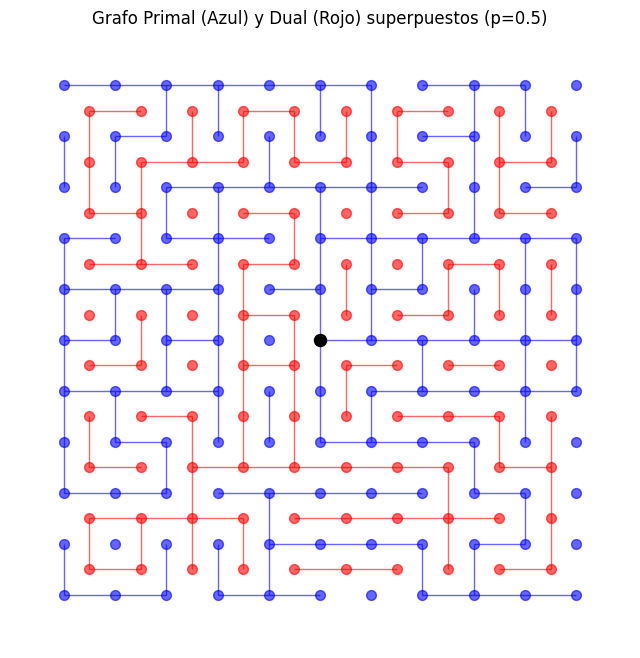

In [49]:
# Ejemplo de uso ( Sobreposicion Dual / Primal )
N = 11
p = 0.5
matriz = asignacion_uniformes(N)
dibujar_grafos_superpuestos(matriz, p)

In [50]:
def dibujar_grafos_separados(matriz, p):

    """
    Dibuja los grafos primal y dual en dos subplots separados.
    """

    grafo_primal = transformacion_matriz_grafo(matriz, p)
    grafo_dual = transformacion_matriz_grafo_dual(matriz, p)

    N = int(np.sqrt(len(matriz)))
    N_dual = N - 1

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Creacion de las posiciones para el grafo primal
    pos_primal = {}
    for i in range(0, N):
        for k in range(0, N):
            pos_primal[i * N + k] = (k, -i)

    # Creacion de las posiciones para el grafo dual
    pos_dual = {}
    for i in range(0, N_dual):
        for k in range(0, N_dual):
            pos_dual[i * N_dual + k] = (k + 0.5, -i - 0.5)

    # Dibujar grafo primal
    nx.draw(grafo_primal, ax=ax1, pos=pos_primal, node_color='blue', edge_color='blue', node_size=50, alpha=0.6)
    ax1.set_title(f"Grafo Primal (p={p})")

    # Marcar el nodo central del grafo primal
    nodo_central = (N // 2) * N + (N // 2)
    nx.draw_networkx_nodes(grafo_primal, pos=pos_primal, nodelist=[nodo_central], node_color='black', node_size=100, ax=ax1)

    # Dibujar grafo dual
    nx.draw(grafo_dual, ax=ax2, pos=pos_dual, node_color='red', edge_color='red', node_size=50, alpha=0.6)
    ax2.set_title(f"Grafo Dual (p={p})")

    # Marcar el centro del grafo dual
    centro_dual_x = (N_dual - 1) / 2 + 0.5
    centro_dual_y = -(N_dual - 1) / 2 - 0.5
    ax2.plot(centro_dual_x, centro_dual_y, 'ko', markersize=10)

    plt.show()

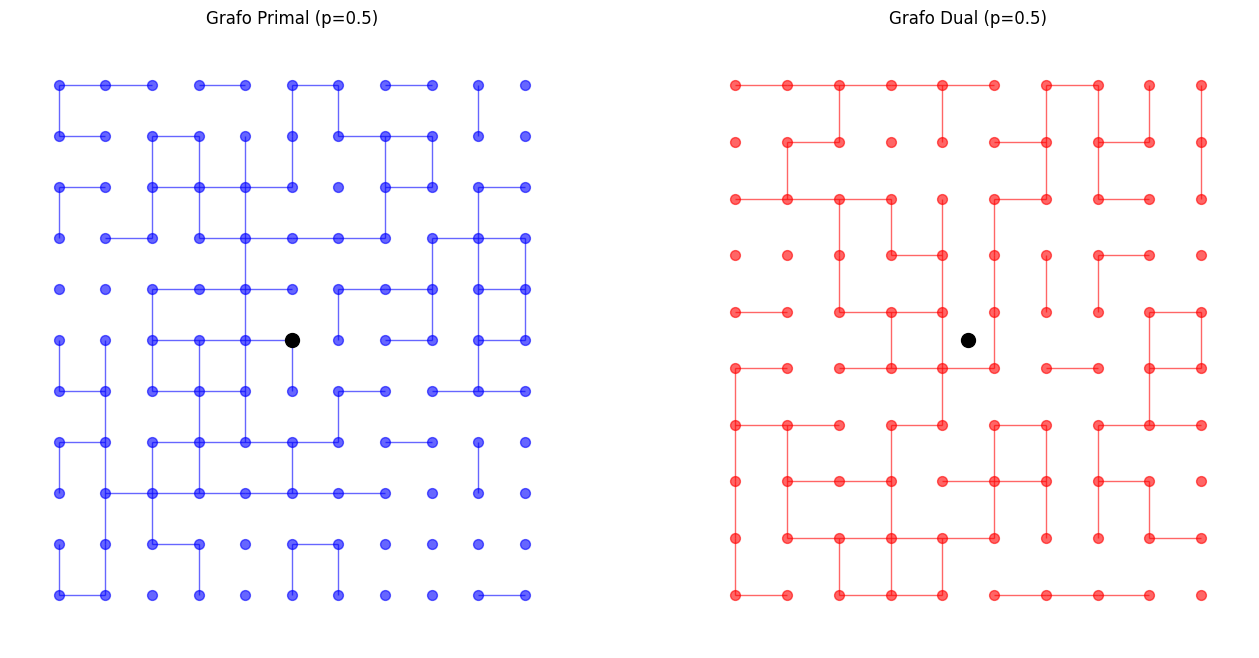

In [53]:
# Ejemplo de uso ( Primal y Dual por separado )
N = 11
p = 0.5
matriz = asignacion_uniformes(N)

dibujar_grafos_separados(matriz, p)

In [61]:
def obtener_componentes_conexas(grafo):
    componentes = list(nx.connected_components(grafo))
    return componentes

def graficar_componentes_conexas(grafo, p):
    componentes = obtener_componentes_conexas(grafo)
    N = int(np.sqrt(len(grafo.nodes())))  # largo de la grilla (N)
    
    # Creacion de las posiciones en forma de grilla
    pos = {}
    for i in range(0, N):
        for k in range(0, N):
            pos[i * N + k] = (i, k)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 12)  # Aumentar el tamaño de la figura
    
    # Generar colores aleatorios en el espacio HSV y convertirlos a RGB
    colores = [mcolors.hsv_to_rgb((random.random(), 0.5 + random.random() * 0.5, 0.5 + random.random() * 0.5)) for _ in range(len(componentes))]
    
    for i, componente in enumerate(componentes):
        nx.draw_networkx_nodes(grafo, pos, nodelist=componente, node_color=[colores[i]], node_size=10, ax=ax)  # Reducir el tamaño de los nodos
        nx.draw_networkx_edges(grafo, pos, edgelist=grafo.subgraph(componente).edges(), edge_color=[colores[i]], width=1, ax=ax)  # Reducir el grosor de las aristas
    
    # Marcar el nodo central
    nodo_central = (N // 2) * N + (N // 2)
    nx.draw_networkx_nodes(grafo, pos, nodelist=[nodo_central], node_color='black', node_size=100, ax=ax)
    
    ax.set_title(f"Componentes Conexas , p={p}")
    plt.show()

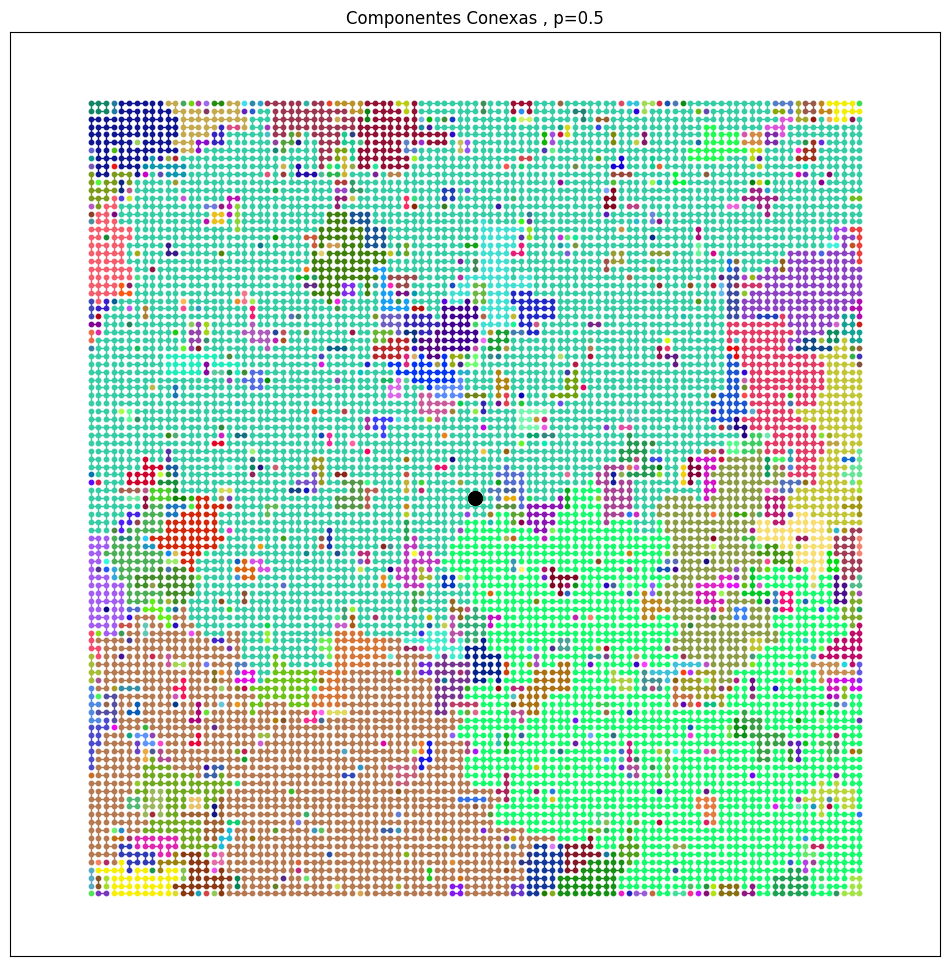

In [63]:
# Ejemplo de uso: ( Componentes Conexas. Tiempo de ejecucion de 8 segundos aprox con parámetros actuales)
N = 101
p = 0.5
matriz = asignacion_uniformes(N)
grafo = transformacion_matriz_grafo(matriz, p)
graficar_componentes_conexas(grafo, p)

### 7.1 Promedio Componente Conexas

In [55]:
def tamaño_promedio_componentes_conexas(grafo):

    """
    Calcula el tamaño promedio de las componentes conexas de un grafo.
    """
    
    componentes = list(nx.connected_components(grafo))
    tamanos = [len(componente) for componente in componentes]
    tamaño_promedio = sum(s**2 for s in tamanos) / sum(tamanos)
    return tamaño_promedio

In [56]:
# Ejemplo de uso
grafo_ej = sampleo_grafo(101, 0.4)
print(tamaño_promedio_componentes_conexas(grafo_ej))

33.23370257817861


In [57]:
def tamaño_promedio_componentes_conexas_multiple(N, p, nf):

    """
    Calcula el tamaño promedio de las componentes conexas de un grafo, promediando sobre varios grafos generados.
    """
    
    tamaños_componentes = 0
    
    for _ in range(nf):
        grafo = sampleo_grafo(N, p)
        tamaños_componentes += tamaño_promedio_componentes_conexas(grafo)
    
    tamaño_promedio = tamaños_componentes/nf
    return tamaño_promedio

# Ejemplo de uso
N = 101
p = 0.5
nf = 10
tamaño_promedio = tamaño_promedio_componentes_conexas_multiple(N, p, nf)
print(f"Tamaño promedio de las componentes conexas: {tamaño_promedio}")

Tamaño promedio de las componentes conexas: 1676.9732183119304


In [58]:
def obtener_tamaños_promedio(N,nf, inf,sup,divisiones):
    
    """
    Función que obtiene los tamaños promedio de las componentes conexas de un grafo, promediando sobre varios grafos generados.

    Observacion: los tamaños promedio son la suma al cuadrado de los tamaños de las componentes conexas dividido por la suma de los tamaños de las componentes conexas.
    """

    valores = np.zeros(divisiones)
    p = np.linspace(inf, sup, divisiones)
    for i in range(divisiones):
        valores[i] = tamaño_promedio_componentes_conexas_multiple(N, p[i], nf)
        print(f"Iteración {i} de {divisiones}")
    return valores

In [59]:
def graficar_tamaños_promedios(valores, inf, sup):

    """
    Grafica los tamaños promedios de las componentes conexas en función de los valores de p.
    """
    
    if valores is None:
        print("La variable 'valores' está vacía.")
        return
    
    x = np.linspace(inf, sup, len(valores))
    y = valores
    
    # Filtrar valores que no sean 0
    mask = (x != 0.0) & (y != 0)
    x = x[mask]
    y = y[mask]
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o', linestyle='-', color='b')
    plt.title('Tamaños Promedios')
    plt.xlabel('Valores de p')
    plt.ylabel('Tamaño Promedio')
    plt.grid(True)
    plt.show()

Iteración 0 de 14
Iteración 1 de 14
Iteración 2 de 14
Iteración 3 de 14
Iteración 4 de 14
Iteración 5 de 14
Iteración 6 de 14
Iteración 7 de 14
Iteración 8 de 14
Iteración 9 de 14
Iteración 10 de 14
Iteración 11 de 14
Iteración 12 de 14
Iteración 13 de 14


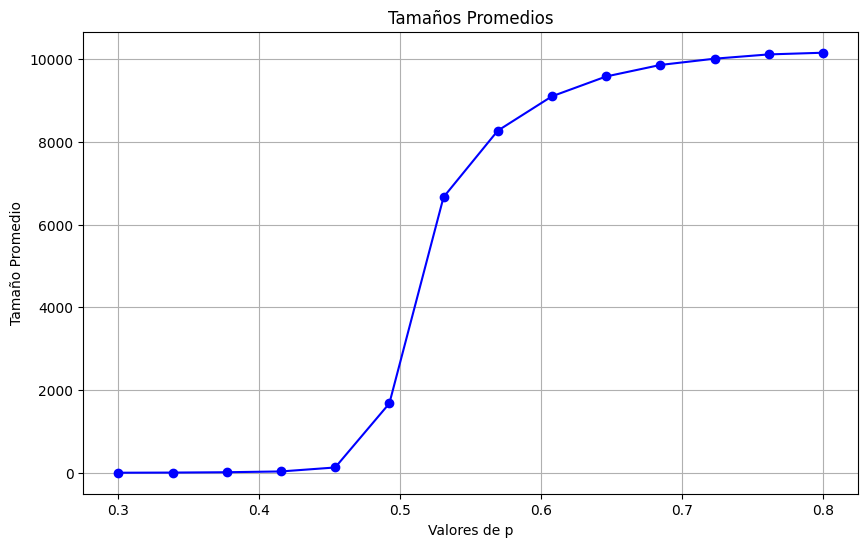

In [60]:
#Ejemplo de uso ( Tiempo de ejecución de 6 segundos aprox)
inf, sup = 0.3, 0.8
valores=obtener_tamaños_promedio(N=101, nf=10,inf=inf, sup=sup, divisiones=14)
graficar_tamaños_promedios(valores, inf,sup)